# Set-up

In [1]:
import os
import gym
import slimevolleygym
import numpy as np

from stable_baselines.ppo1 import PPO1
from stable_baselines import TRPO
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import logger
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.bench import Monitor

from model import BnnPolicy

C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\notes\Anaconda3\envs\slime-rl\lib\

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [941]:
import gym
import slimevolleygym
from tqdm import tqdm_notebook as tqdm

def evaluate(p1, p2, n=100):
    env = gym.make("SlimeVolley-v0")
    p1_scores=[]
    p2_scores=[]
    
    for i in tqdm.tqdm(range(n)):
        obs1 = env.reset()
        obs2 = obs1 # both sides always see the same initial observation.

        done = False
        total_reward = 0

        while not done:

            action1, _ = p1.predict(obs1)
            action2, _ = p2.predict(obs2)

            obs1, reward, done, info = env.step(action1, action2) # extra argument
            obs2 = info['otherObs']

            total_reward += reward
            # env.render()
        p1_scores.append(total_reward)
        p2_scores.append(-total_reward)
        
    p1_score = np.mean(p1_scores)
    p2_score = np.mean(p2_scores)
    
    p1_var = np.std(p1_scores)
    p2_var = np.std(p2_scores)
    
    print(f"Player 1: {p1_score} +- {p1_var:.3f}")
    print(f"Player 2: {p2_score} +- {p2_var:.3f}")
        
    return p1_score, p2_score, p1_var, p2_var

In [942]:
def get_dataset(env, model1, model2, n=10):
    t = 0
    obs1 = env.reset()
    obs2 = obs1
    done = False
    total_reward = 0
    batch = []
    
    while not done:
        var1 = compute_var(model1, obs1, n=n)
        var2 = compute_var(model2, obs2, n=n)
        
        action1, _ = model1.predict(obs1)
        action2, _ = model2.predict(obs2)
        obs1, reward, done, info = env.step(action1, action2) # extra argument
        obs2 = info['otherObs']
        total_reward += reward
        t += 1
        
        batch.append((t, *obs1, *action1, *action2, reward, var1, var2))
        
    return pd.DataFrame(batch, columns=['t', 'self_x', 'self_y', 'self_dx', 'self_dy', 'ball_x', 'ball_y',
                                        'ball_dx', 'ball_dy', 'opp_x', 'opp_y', 'opp_dx', 'opp_dy',
                                        'action1_1', 'action1_2', 'action1_3',
                                        'action2_1', 'action2_2', 'action2_3', 'reward', 'var1', 'var2'])


def get_datasets(env, model1, model2, trials=100, n=10):
    datasets = []
    for n in tqdm(range(trials)):
        datasets.append(get_dataset(env, model1, model2, n=n))
    return pd.concat(datasets, ignore_index=True)

In [622]:
from scipy.stats import entropy

def compute_var(model, obs, n=100):
    """Given an obs, compute variance for the models"""
    counts = [0] * (2**3)
    actions = []
    for _ in range(n):
        a, _ = model.predict(obs)
        counts[np.dot(a, [1,2,4]).astype(int)] += 1
        
    return entropy(counts, base=2)

In [955]:
def plot_uncertainty(timesteps, series, label="", g=20, c=None, line_alpha=1, fill_alpha=0.2):
    n = len(series) // g
    mu = series.rolling(n).mean()
    sigma = series.rolling(n).std()

    plt.plot(timesteps, mu, label=label, color=c, alpha=line_alpha)
    plt.fill_between(timesteps, mu-2*sigma, mu+2*sigma, alpha=fill_alpha, color=c)

In [366]:
def plot_ball_coordinates(batch, left, right, alpha=0.006):
    plt.title(f"Ball coordinates - {left} vs {right}")
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.scatter(batch['ball_x'], batch['ball_y'], alpha=alpha, c=batch['ball_y'], cmap='viridis')
    plt.show()

def plot_agent_coordinates(batch, left, right, win=None, ball=None, alpha=0.01, bins=20):
    if win == 'right':
        batch = batch[batch['reward']==1]
    if win == 'left':
        batch = batch[batch['reward']==-1]
    if win == 'both':
        batch = batch[(batch['reward']==1) | (batch['reward']==-1)]
        
    if ball == 'right':
        batch = batch[batch['ball_x'] > 0]
    if ball == 'left':
        batch = batch[batch['ball_x'] < 0]
        
    xs = pd.concat([batch['self_x'], -batch['opp_x']], ignore_index=True)
    ys = pd.concat([batch['self_y'], batch['opp_y']], ignore_index=True)
    plt.title(f"Agent x-coordinate - {left} vs {right}")
    plt.xlabel("x-axis")    
    plt.hist(batch['self_x'], bins=bins, label=right)
    plt.hist(-batch['opp_x'], bins=bins, label=left)
    plt.legend(loc='best')
    plt.show()

# Expert Experiments

# PPO-BNN-Expert Performance Plot

In [967]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/expert/ppo-bnn/"
pd_ppo_bnn_expert = [pd.read_csv(os.path.join(LOGDIR, f"{i}/progress.csv")) for i in range(1, 11)]

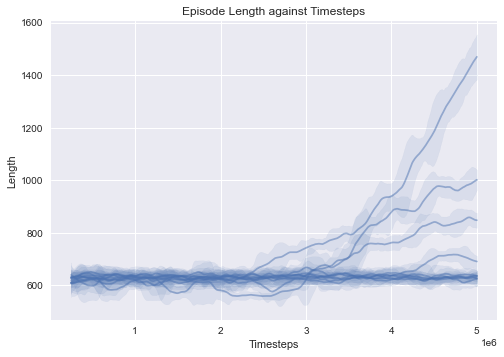

In [981]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
for i in range(10):
    plot_uncertainty(pd_ppo_bnn_expert[i]['TimestepsSoFar'],
                     pd_ppo_bnn_expert[i]['EpLenMean'],
                     g=20, c="#4C72B0", line_alpha=0.5, fill_alpha=0.1)
plt.show()

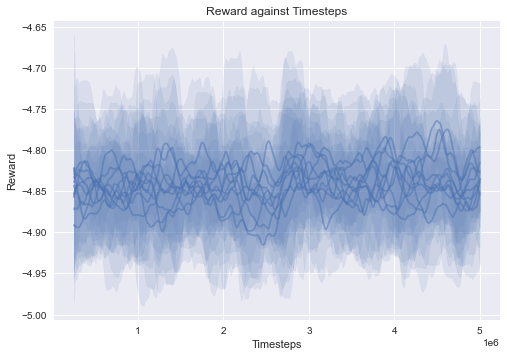

In [982]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
for i in range(10):
    plot_uncertainty(pd_ppo_bnn_expert[i]['TimestepsSoFar'],
                     pd_ppo_bnn_expert[i]['EpRewMean'],
                     g=20, c='#4C72B0', line_alpha=0.5, fill_alpha=0.1)
plt.show()

# TRPO-DNN-Expert Performance Plot

In [921]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/expert/trpo-dnn/"
pd_trpo_dnn_expert = [pd.read_csv(os.path.join(LOGDIR, f"{i}/progress.csv")) for i in range(1, 11)]
LOGDIR = "exp/expert/trpo-bnn/"
pd_trpo_bnn_expert = [pd.read_csv(os.path.join(LOGDIR, f"{i}/progress.csv")) for i in range(1, 11)]

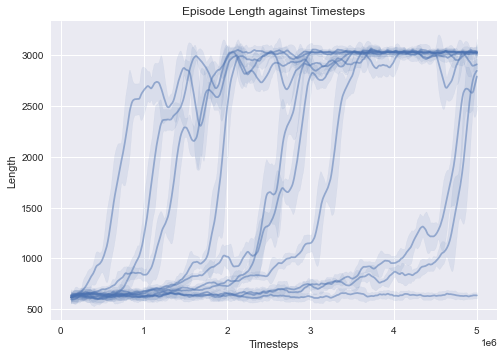

In [958]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
for i in range(10):
    plot_uncertainty(pd_trpo_dnn_expert[i]['TimestepsSoFar'],
                     pd_trpo_dnn_expert[i]['EpLenMean'],
                     g=40, c='#4C72B0', line_alpha=0.5, fill_alpha=0.1)
plt.show()

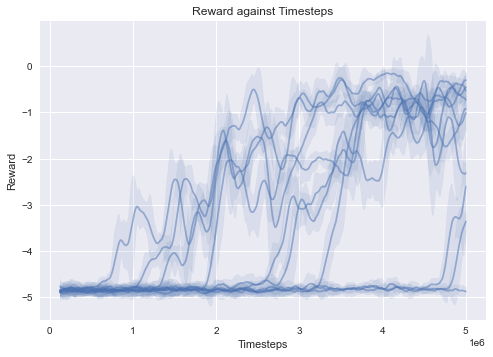

In [959]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
for i in range(10):
    plot_uncertainty(pd_trpo_dnn_expert[i]['TimestepsSoFar'],
                     pd_trpo_dnn_expert[i]['EpRewMean'],
                     g=40, c='#4C72B0', line_alpha=0.5, fill_alpha=0.1)
plt.show()

# TRPO-BNN-Expert Performance Plot

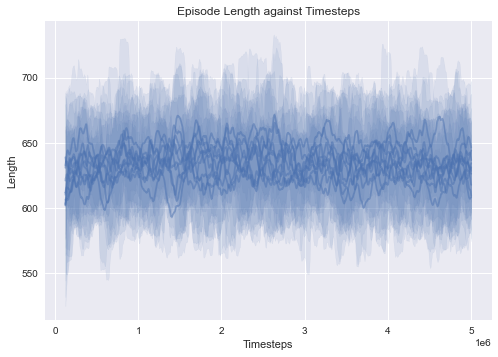

In [984]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
for i in range(10):
    plot_uncertainty(pd_trpo_bnn_expert[i]['TimestepsSoFar'],
                     pd_trpo_bnn_expert[i]['EpLenMean'],
                     g=40, c='#4C72B0', line_alpha=0.5, fill_alpha=0.1)
plt.show()

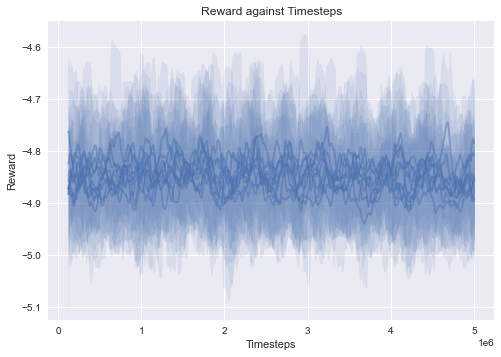

In [983]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
for i in range(10):
    plot_uncertainty(pd_trpo_bnn_expert[i]['TimestepsSoFar'],
                     pd_trpo_bnn_expert[i]['EpRewMean'],
                     g=40, c='#4C72B0', line_alpha=0.5, fill_alpha=0.1)
plt.show()

# PPO-DNN-Self vs PPO-BNN-Self Performance

In [4]:
ppo_dnn = PPO1.load(os.path.join("exp/self/ppo-dnn", "final_model"))
ppo_bnn = PPO1.load(os.path.join("exp/self/ppo-bnn", "final_model"))

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [33]:
dnn_score, bnn_score, dnn_var, bnn_var = evaluate(dnn, bnn, n=1000)


DNN: -4.031 += 1.279
BNN: 4.031 += 1.279


In [45]:
trpo_dnn = TRPO.load(os.path.join("exp/self/trpo-dnn", "final_model"))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [47]:
evaluate(trpo_dnn, ppo_dnn, n=100)
evaluate(trpo_dnn, ppo_bnn, n=100)


Player 1: -0.57 +- 2.688
Player 2: 0.57 +- 2.688



Player 1: -4.25 +- 1.081
Player 2: 4.25 +- 1.081


(-4.25, 4.25, 1.0805091392487154, 1.0805091392487154)

# PPO-DNN-Self Uncertainty

In [625]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")
ppo_dnn_bnn_batch = get_datasets(env, ppo_bnn, ppo_dnn, trials=100, n=10)

ppo_dnn_bnn_batch.to_csv("ppo_dnn_bnn_batch.csv", index=False)

C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2544: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [631]:
# Entropy at uncertain region: Near the net (|x|<0.5 & y < 1)

dnn_var = batch[(abs(batch['ball_x']) < 0.1) & (batch['ball_y'] < 1)]['var1'].mean()
bnn_var = batch[(abs(batch['ball_x']) < 0.1) & (batch['ball_y'] < 1)]['var2'].mean()

print(f"When velocity exceeds 99th percentile, entropy of DNN={dnn_var:.3f}, BNN={bnn_var:.3f}")

When velocity exceeds 99th percentile, entropy of DNN=2.180, BNN=1.586


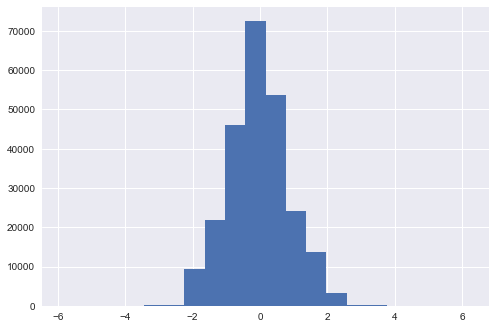

When velocity exceeds 99th percentile, entropy of DNN=1.860, BNN=1.451


In [630]:
# Entropy at uncertain region: Velocity > 99th percentile

batch = ppo_dnn_bnn_batch

plt.hist(batch['ball_dx'], bins=20)
plt.show()

greaterthan = np.percentile(batch['ball_dx'], 99)
smallerthan = np.percentile(batch['ball_dx'], 1)

dnn_var = batch[(batch['ball_dx'] > greaterthan) | (batch['ball_dx'] < smallerthan)]['var1'].mean()
bnn_var = batch[(batch['ball_dx'] > greaterthan) | (batch['ball_dx'] < smallerthan)]['var2'].mean()

print(f"When velocity exceeds 99th percentile, entropy of DNN={dnn_var:.3f}, BNN={bnn_var:.3f}")

# PPO-DNN-Self and PPO-BNN-Self Agent Behaviour

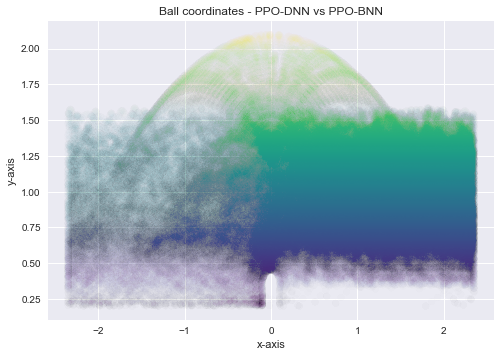

In [350]:
plot_ball_coordinates(ppo_dnn_bnn_batch, "PPO-DNN", "PPO-BNN", alpha=0.007)

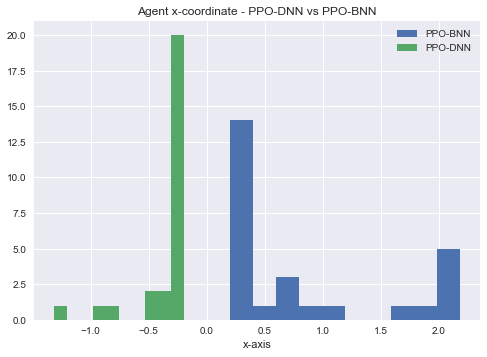

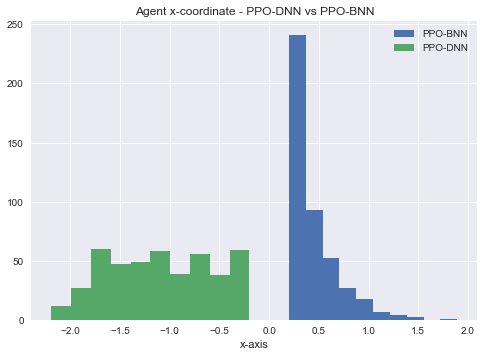

In [373]:
plot_agent_coordinates(ppo_dnn_bnn_batch, 'PPO-DNN', 'PPO-BNN', win='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_batch, 'PPO-DNN', 'PPO-BNN', win='right', bins=10)

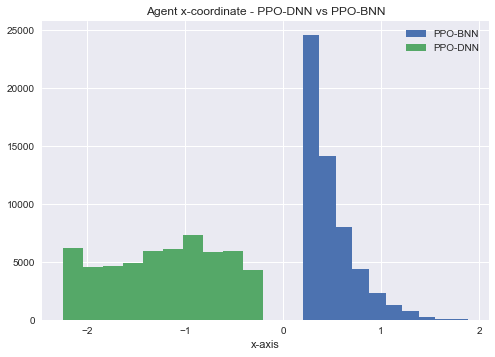

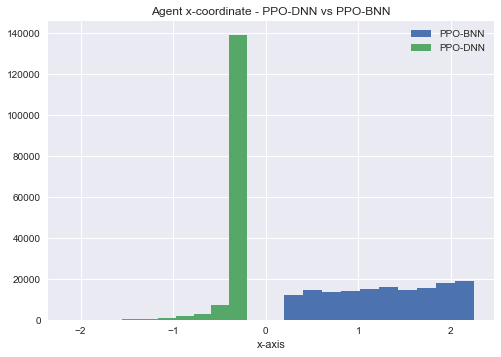

In [371]:
plot_agent_coordinates(ppo_dnn_bnn_batch, 'PPO-DNN', 'PPO-BNN', ball='left', bins=10)
plot_agent_coordinates(ppo_dnn_bnn_batch, 'PPO-DNN', 'PPO-BNN', ball='right', bins=10)

# PPO-DNN-Self and PPO-BNN-Self Performance Plot

In [375]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/self/ppo-dnn"
pd_ppo_dnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

LOGDIR = "exp/self/ppo-bnn"
pd_ppo_bnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

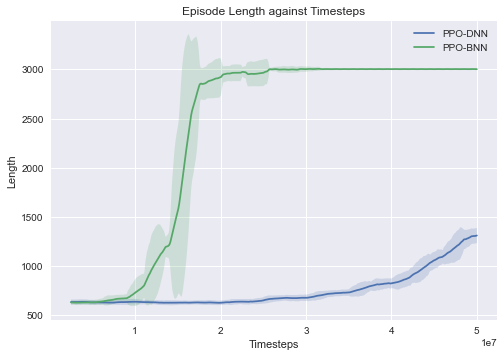

In [842]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
plot_uncertainty(pd_ppo_dnn_self['TimestepsSoFar'], pd_ppo_dnn_self['EpLenMean'], label="PPO-DNN")
plot_uncertainty(pd_ppo_dnn_self['TimestepsSoFar'], pd_ppo_bnn_self['EpLenMean'], label="PPO-BNN")
plt.legend(loc='best')
plt.show()

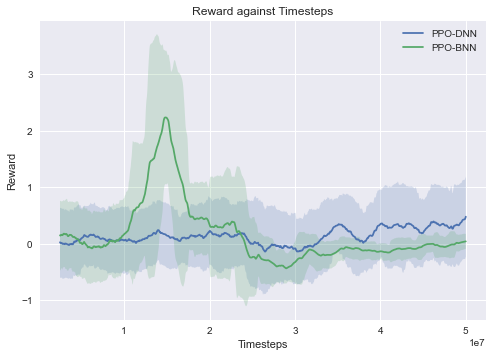

In [843]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plot_uncertainty(pd_ppo_dnn_self['TimestepsSoFar'], pd_ppo_dnn_self['EpRewMean'], label="PPO-DNN")
plot_uncertainty(pd_ppo_dnn_self['TimestepsSoFar'], pd_ppo_bnn_self['EpRewMean'], label="PPO-BNN")
plt.legend(loc='best')
plt.show()

In [659]:
ppo_dnn_rew = pd_ppo_dnn_self['EpRewMean'][-100_000:]
ppo_bnn_rew = pd_ppo_bnn_self['EpRewMean'][-100_000:]

print(f"Reward Variance of Last 100K: PPO-DNN={np.var(ppo_dnn_rew):.3f}, PPO-BNN={np.var(ppo_bnn_rew):.3f}")

Reward Variance of Last 100K: PPO-DNN=0.138, PPO-BNN=0.029


# TRPO-DNN-Self and TRPO-BNN-Self Performance Plot

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/self/trpo-dnn"
pd_trpo_dnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

LOGDIR = "exp/self/trpo-bnn"
pd_trpo_bnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

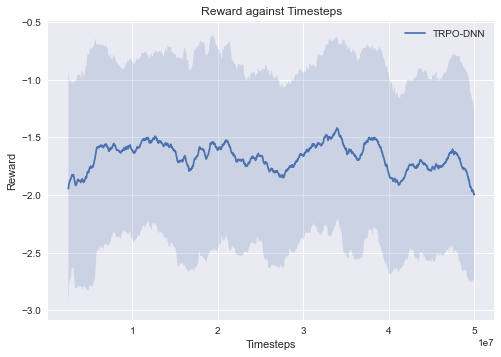

In [844]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plot_uncertainty(pd_trpo_bnn_self['TimestepsSoFar'], pd_trpo_bnn_self['EpRewMean'], label="TRPO-DNN")
plt.legend(loc='best')
plt.show()

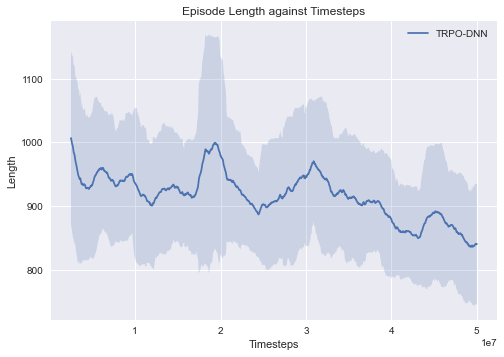

In [845]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
plot_uncertainty(pd_trpo_bnn_self['TimestepsSoFar'], pd_trpo_bnn_self['EpLenMean'], label="TRPO-DNN")
plt.legend(loc='best')
plt.show()

# TRPO-DNN-Self and TRPO-BNN-Self Performance

Currently wrong

In [5]:
trpo_dnn = TRPO.load(os.path.join("exp/self/trpo-dnn", "final_model"))
trpo_bnn = TRPO.load(os.path.join("exp/self/trpo-bnn", "final_model"))

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [9]:
dnn_score, bnn_score, dnn_var, bnn_var = evaluate(trpo_dnn, trpo_bnn, n=100)


Player 1: 0.72 +- 2.933
Player 2: -0.72 +- 2.933


In [621]:
evaluate(ppo_dnn, trpo_dnn, n=1000)
evaluate(trpo_dnn, ppo_bnn, n=1000)


Player 1: 0.644 +- 2.730
Player 2: -0.644 +- 2.730



Player 1: -4.16 +- 1.066
Player 2: 4.16 +- 1.066


(-4.16, 4.16, 1.0660206376989143, 1.0660206376989143)

In [11]:
evaluate(ppo_dnn, trpo_dnn, n=1000)  # PPO-DNN > TRPO-DNN: 1.6
evaluate(ppo_dnn, trpo_bnn, n=10)  # PPO-DNN > TRPO-BNN: 3.1
evaluate(ppo_dnn, ppo_bnn, n=10)  # PPO-DNN < PPO-BNN: -3.6

evaluate(trpo_dnn, trpo_bnn, n=10)  # TRPO-DNN > TRPO-BNN: 1.5
evaluate(trpo_dnn, ppo_bnn, n=10)  # TRPO-DNN < PPO-BNN: -4.0

evaluate(trpo_bnn, ppo_bnn, n=10)  # TRPO-BNN < PPO-BNN: -4.4


Player 1: 1.6 +- 2.289
Player 2: -1.6 +- 2.289



Player 1: 3.1 +- 1.578
Player 2: -3.1 +- 1.578



Player 1: -3.6 +- 1.356
Player 2: 3.6 +- 1.356



Player 1: 1.5 +- 2.500
Player 2: -1.5 +- 2.500



Player 1: -4.0 +- 0.894
Player 2: 4.0 +- 0.894



Player 1: -4.4 +- 1.020
Player 2: 4.4 +- 1.020


(-4.4, 4.4, 1.0198039027185568, 1.0198039027185568)

# TRPO-DNN-Self and TRPO-BNN-Self Agent Behaviour

In [628]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")
trpo_dnn_ppodnn_batch = get_datasets(env, trpo_dnn, ppo_dnn, trials=100, n=10)
trpo_dnn_ppobnn_batch = get_datasets(env, trpo_dnn, ppo_bnn, trials=100, n=10)

trpo_dnn_ppodnn_batch.to_csv("trpo_dnn_ppodnn_batch.csv", index=False)
trpo_dnn_ppobnn_batch.to_csv("trpo_dnn_ppobnn_batch.csv", index=False)

C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2544: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


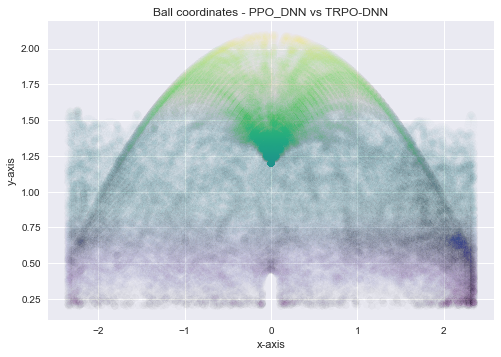

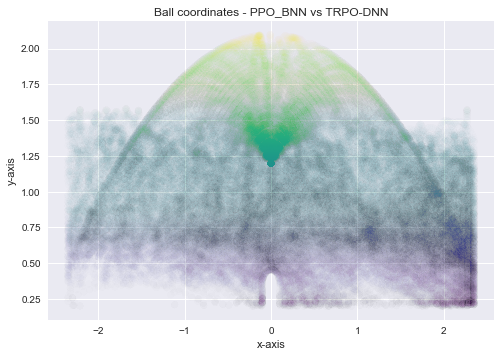

In [134]:
plt.title("Ball coordinates - PPO_DNN vs TRPO-DNN")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.scatter(trpo_dnn_ppodnn_batch['ball_x'], trpo_dnn_ppodnn_batch['ball_y'],
            alpha=0.007, c=trpo_dnn_ppodnn_batch['ball_y'], cmap='viridis')
plt.show()

plt.title("Ball coordinates - PPO_BNN vs TRPO-DNN")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.scatter(trpo_dnn_ppobnn_batch['ball_x'], trpo_dnn_ppobnn_batch['ball_y'],
            alpha=0.007, c=trpo_dnn_ppobnn_batch['ball_y'], cmap='viridis')
plt.show()

# TRPO Performance Cruve

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/self/trpo-dnn"
pd_trpo_dnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

LOGDIR = "exp/self/trpo-bnn"
pd_trpo_bnn_self = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

# PPO-DNN-Multi and PPO-BNN-Multi Performance Plots

In [933]:
ppo_dnn_multi = PPO1.load(os.path.join("exp/multi/ppo-dnn", "final_model"))
ppo_bnn_multi = PPO1.load(os.path.join("exp/multi/ppo-bnn", "final_model"))

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [922]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

LOGDIR = "exp/multi/ppo-dnn"
pd_ppo_dnn_multi = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

LOGDIR = "exp/multi/ppo-bnn"
pd_ppo_bnn_multi = pd.read_csv(os.path.join(LOGDIR, "progress.csv"))

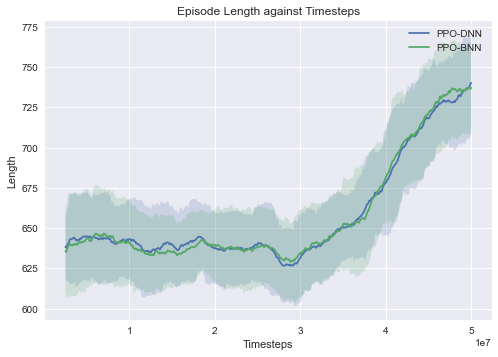

In [945]:
plt.title("Episode Length against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Length")
plot_uncertainty(pd_ppo_dnn_multi['TimestepsSoFar'], pd_ppo_dnn_multi['EpLenMean'], label="PPO-DNN")
plot_uncertainty(pd_ppo_bnn_multi['TimestepsSoFar'], pd_ppo_bnn_multi['EpLenMean'], label="PPO-BNN")
plt.legend(loc='best')
plt.show()

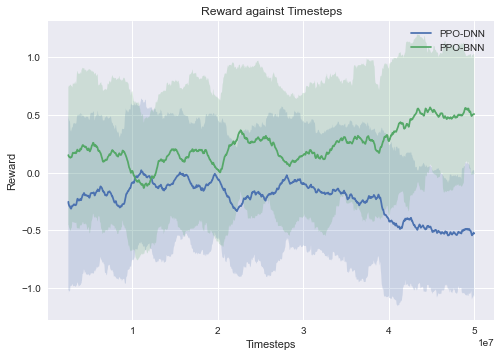

In [946]:
plt.title("Reward against Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plot_uncertainty(pd_ppo_dnn_multi['TimestepsSoFar'], pd_ppo_dnn_multi['EpRewMean'], label="PPO-DNN")
plot_uncertainty(pd_ppo_bnn_multi['TimestepsSoFar'], pd_ppo_bnn_multi['EpRewMean'], label="PPO-BNN")
plt.legend(loc='best')
plt.show()

# PPO-DNN-Multi and PPO-BNN-Multi Performance

In [937]:
ppo_dnn_multi_score, ppo_bnn_multi_score, ppo_dnn_multi_var, ppo_bnn_muli_var = evaluate(ppo_dnn_multi, ppo_bnn_multi, n=10)


Player 1: -0.5 +- 2.655
Player 2: 0.5 +- 2.655


# PPO-DNN-Multi and PPO-BNN-Multi Uncertainty

In [943]:
import gym
import slimevolleygym

env = gym.make("SlimeVolley-v0")
ppo_dnn_bnn_multi_batch = get_datasets(env, ppo_bnn_multi, ppo_dnn_multi, trials=100, n=10)
ppo_dnn_bnn_multi_batch.to_csv("ppo_dnn_bnn_multi_batch.csv", index=False)

C:\Users\notes\Anaconda3\envs\slime-rl\lib\site-packages\ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\notes\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:2544: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [989]:
# Entropy at uncertain region: Near the net (|x|<0.5 & y < 1)
batch = ppo_dnn_bnn_multi_batch
dnn_var = batch[(abs(batch['ball_x']) < 0.1) & (batch['ball_y'] < 1)]['var1'].mean()
bnn_var = batch[(abs(batch['ball_x']) < 0.1) & (batch['ball_y'] < 1)]['var2'].mean()

print(f"When ball is near the net, entropy of DNN={dnn_var:.3f}, BNN={bnn_var:.3f}")

When ball is near the net, entropy of DNN=2.459, BNN=2.184


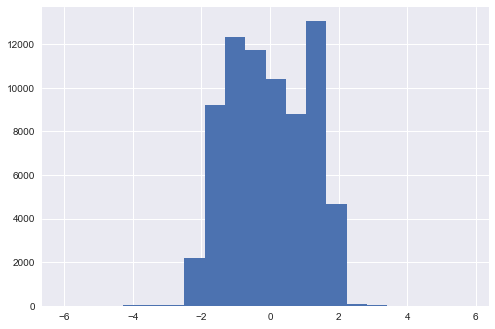

When velocity exceeds 99th percentile, entropy of DNN=2.559, BNN=2.261


In [992]:
# Entropy at uncertain region: Velocity > 99th percentile

batch = ppo_dnn_bnn_multi_batch

plt.hist(batch['ball_dx'], bins=20)
plt.show()

greaterthan = np.percentile(batch['ball_dx'], 99)
smallerthan = np.percentile(batch['ball_dx'], 1)

dnn_var = batch[(batch['ball_dx'] > greaterthan) | (batch['ball_dx'] < smallerthan)]['var1'].mean()
bnn_var = batch[(batch['ball_dx'] > greaterthan) | (batch['ball_dx'] < smallerthan)]['var2'].mean()

print(f"When velocity exceeds 99th percentile, entropy of DNN={dnn_var:.3f}, BNN={bnn_var:.3f}")

# PPO-DNN-Multi and PPO-BNN-Multi Agent Behaviour

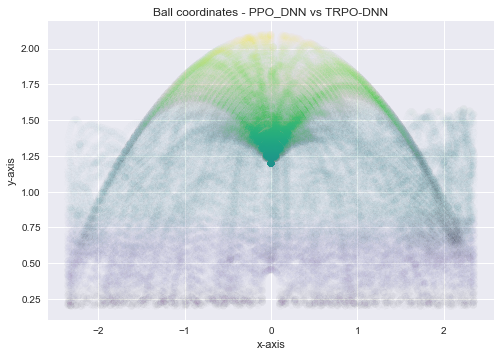

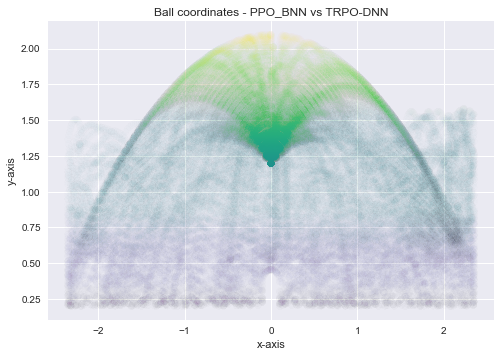

In [985]:
plt.title("Ball coordinates - PPO_DNN vs TRPO-DNN")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.scatter(ppo_dnn_bnn_multi_batch['ball_x'], ppo_dnn_bnn_multi_batch['ball_y'],
            alpha=0.007, c=ppo_dnn_bnn_multi_batch['ball_y'], cmap='viridis')
plt.show()

plt.title("Ball coordinates - PPO_BNN vs TRPO-DNN")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.scatter(ppo_dnn_bnn_multi_batch['ball_x'], ppo_dnn_bnn_multi_batch['ball_y'],
            alpha=0.007, c=ppo_dnn_bnn_multi_batch['ball_y'], cmap='viridis')
plt.show()